<a href="https://colab.research.google.com/github/ehabsuliman/Essay-Grading-Transformer/blob/main/Grading_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.10: Fast Mistral patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)


Unsloth 2025.5.10 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [3]:
alpaca_prompt = """Below is a prompt and a partial response. Complete the response appropriately.

### Prompt:
{}

### Response:
{}"""


In [4]:
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    prompts    = examples["prompt"]
    completions = examples["completion"]
    texts = []
    for prompt, completion in zip(prompts, completions):
        text = alpaca_prompt.format(prompt, completion) + EOS_TOKEN
        texts.append(text)
    return { "text": texts }


In [5]:
from datasets import load_dataset

# Load your JSONL file
dataset = load_dataset("json", data_files="/content/NLP_exam_score.jsonl", split="train")

# Format the prompts using your custom function
dataset = dataset.map(formatting_prompts_func, batched=True)


In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30, # Set num_train_epochs = 1 for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

In [7]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.372900
2,2.414700
3,1.915200
4,1.641800
5,1.408700
6,1.134000
7,0.942500
8,0.798600
9,0.742000
10,0.615600


In [8]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
4.756 GB of memory reserved.


In [9]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

273.6456 seconds used for training.
4.56 minutes used for training.
Peak reserved memory = 4.756 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 32.264 %.
Peak reserved memory for training % of max memory = 0.0 %.


In [10]:
save_path = "/content/drive/MyDrive/model-v3"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/model-v3/tokenizer_config.json',
 '/content/drive/MyDrive/model-v3/special_tokens_map.json',
 '/content/drive/MyDrive/model-v3/chat_template.jinja',
 '/content/drive/MyDrive/model-v3/tokenizer.model',
 '/content/drive/MyDrive/model-v3/added_tokens.json',
 '/content/drive/MyDrive/model-v3/tokenizer.json')

In [11]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/model-v3",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
model.eval()


==((====))==  Unsloth 2025.5.10: Fast Mistral patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Will load /content/drive/MyDrive/model-v3 as a legacy tokenizer.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): l

In [12]:
import torch

prompt = """Below is a prompt and a partial response. Complete the response appropriately.

### Prompt:
Question: Explain overfittng in machine learning?
Reference Answer: Overfitting occurs when a machine learning model learns the training data too well,
                  including its noise and outliers, resulting in poor generalization to new data.
                  The model performs well on the training set but poorly on unseen data
Student Answer: overfitting is when the model preforms very well on the training data and dont do well on the unseen test data
   it dont generalize well like it remember the data but dont understand it
Mark Scheme: Defines overfitting clearly
             Mentions memorization or learning noise
             Addresses poor generalization
             Provides a contrast between training and test performance

### Response:
"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Below is a prompt and a partial response. Complete the response appropriately.

### Prompt:
Question: Explain overfittng in machine learning?
Reference Answer: Overfitting occurs when a machine learning model learns the training data too well,
                  including its noise and outliers, resulting in poor generalization to new data.
                  The model performs well on the training set but poorly on unseen data
Student Answer: overfitting is when the model preforms very well on the training data and dont do well on the unseen test data
   it dont generalize well like it remember the data but dont understand it
Mark Scheme: Defines overfitting clearly
             Mentions memorization or learning noise
             Addresses poor generalization
             Provides a contrast between training and test performance

### Response:
Score:

### Response:
 75
Rationale: Good explanation of overfitting but lacks contrast between training and test data.


In [14]:
import json
import torch

all_outputs = []

# Process each line (each prompt) in the JSONL file
with open("/content/Test.jsonl", "r") as f:
    for line in f:
        entry = json.loads(line)
        prompt = entry["prompt"]

        # Tokenize and generate
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=100,
                temperature=0.7,
                top_p=0.9,
                do_sample=True,
                eos_token_id=tokenizer.eos_token_id,
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Append both prompt and response to output list
        all_outputs.append({
            "prompt": prompt,
            "response": response.strip()
        })

# Save all outputs to a new JSON file
with open("/content/generated_responses-v3.json", "w") as out_file:
    json.dump(all_outputs, out_file, ensure_ascii=False, indent=2)

print("All responses generated and saved to generated_responses-v3.json")


All responses generated and saved to generated_responses-v3.json


In [17]:
import json

# Input and output file paths
input_file = "/content/Test.jsonl"
output_file = "True_sample.json"

# List to store the extracted data
extracted_data = []

# Read and extract from each line
with open(input_file, "r", encoding="utf-8") as infile:
    for line in infile:
        data = json.loads(line)
        rationale = data.get("completion", "")

        # Extract score and rationale from the completion
        if "Rationale:" in rationale:
            parts = rationale.split("Rationale:")
            score = parts[0].strip()
            rationale_text = parts[1].strip()

            try:
                score_value = int(score)
            except ValueError:
                score_value = None
        else:
            score_value = None
            rationale_text = rationale.strip()

        # Save as dictionary
        extracted_data.append({
            "true_score": score_value,
            "true_rationale": rationale_text
        })

# Write output to JSON file
with open(output_file, "w", encoding="utf-8") as outfile:
    json.dump(extracted_data, outfile, ensure_ascii=False, indent=2)

print(f"Extraction complete. Saved to '{output_file}'.")


Extraction complete. Saved to 'True_sample.json'.


In [16]:
import json
import re

# Load the data
input_path = "/content/generated_responses-v3.json"
output_path = "/content/extracted_rationale_scores(pred)v3.json"

with open(input_path, "r", encoding="utf-8") as infile:
    data = json.load(infile)

# Process and extract predicted_score and generated_rationale
extracted_data = []

for item in data:
    response_text = item.get("response", "")

    # Extract score using regex (e.g., a number after 'Response:')
    score_match = re.search(r"### Response:\s*(\d+)", response_text)
    predicted_score = int(score_match.group(1)) if score_match else None

    # Extract rationale (text after 'Rationale:')
    rationale_match = re.search(r"Rationale:\s*(.*)", response_text, re.DOTALL)
    generated_rationale = rationale_match.group(1).strip() if rationale_match else None

    extracted_data.append({
        "predicted_score": predicted_score,
        "generated_rationale": generated_rationale
    })

# Save to JSON file
with open(output_path, "w", encoding="utf-8") as outfile:
    json.dump(extracted_data, outfile, indent=2, ensure_ascii=False)

print(f"Extracted data saved to {output_path}")


Extracted data saved to /content/extracted_rationale_scores(pred)v3.json


In [18]:
import json

# Input paths
file1_path = "/content/extracted_rationale_scores(pred)v3.json"
file2_path = "/content/True_sample.json"
output_path = "/content/test_data-v3.json"

# Load both files
with open(file1_path, "r", encoding="utf-8") as f1:
    predicted_data = json.load(f1)

with open(file2_path, "r", encoding="utf-8") as f2:
    true_data = json.load(f2)

# Concatenate corresponding entries
combined = []
for pred, true in zip(predicted_data, true_data):
    merged = {
        "predicted_score": pred["predicted_score"],
        "generated_rationale": pred["generated_rationale"],
        "true_score": true["true_score"],
        "true_rationale": true["true_rationale"]
    }
    combined.append(merged)

# Save to output file
with open(output_path, "w", encoding="utf-8") as out:
    for entry in combined:
        json.dump(entry, out, ensure_ascii=False)
        out.write("\n")

print(f"Combined file saved to {output_path}")


Combined file saved to /content/test_data-v3.json


In [ ]:
import torch

prompt = """Below is a prompt and a partial response. Complete the response appropriately.

### Prompt:
Question: What is the role of game playing in ai in modern artificial intelligence systems?
Reference Answer: Game Playing in AI plays a vital role in AI by providing techniques and tools to solve domain-specific problems. It enables systems to perform tasks such as reasoning, planning, interaction, or adaptation depending on the context of the topic.
It enables systems to perform tasks such as reasoning, planning, interaction, or adaptation depending on the context of the topic.
Student Answer: game playing in ai is when AI works like a computer game or hardware
Mark Scheme: 1.Defines game playing in ai
          2. Mentions key function in AI
          3. Provides a relevant application or example
          4. Connects to AI goals like automation or decision-making
### Response:
"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Below is a prompt and a partial response. Complete the response appropriately.

### Prompt:
Question: What is the role of game playing in ai in modern artificial intelligence systems?
Reference Answer: Game Playing in AI plays a vital role in AI by providing techniques and tools to solve domain-specific problems. It enables systems to perform tasks such as reasoning, planning, interaction, or adaptation depending on the context of the topic. 
It enables systems to perform tasks such as reasoning, planning, interaction, or adaptation depending on the context of the topic.
Student Answer: game playing in ai is when AI works like a computer game or hardware
Mark Scheme: 1.Defines game playing in ai
          2. Mentions key function in AI
          3. Provides a relevant application or example
          4. Connects to AI goals like automation or decision-making
### Response:
Score:

### Response:
 0
Rationale: Incorrectly focuses on hardware and gaming rather than AI applications.


In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
import pandas as pd

# Load the JSON data, assuming it's JSON Lines format
df = pd.read_json('/content/AI_Topics_Rationales_Scores_Evaluate.json', lines=True)
print(df.columns)

Index(['predicted_score', 'generated_rationale', 'true_score',
       'true_rationale'],
      dtype='object')


In [ ]:
import pandas as pd

# Load the JSON data
df = pd.read_json('/content/AI_Topics_Rationales_Scores_Evaluate.json', lines=True)

# Required columns
required_cols = ["generated_rationale", "true_rationale", "predicted_score", "true_score"]

# Verify columns
assert all(col in df.columns for col in required_cols), "Missing required columns."
print("All required columns are present:", df.columns.tolist())

All required columns are present: ['predicted_score', 'generated_rationale', 'true_score', 'true_rationale']


In [ ]:
missing_data = df[required_cols].isnull().any(axis=1)
if missing_data.any():
    print("Rows with missing data:")
    print(df[missing_data])
else:
    print("No missing data in required columns.")

No missing data in required columns.


In [19]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------
# Load Your Dataset
# ----------------------
file_path = "/content/test_data-v3.json"

# Load JSON Lines data
try:
    df = pd.read_json(file_path, lines=True)
except ValueError as e:
    print(f"Error loading JSON: {e}")
    exit(1)

# Required columns
required_cols = ["generated_rationale", "true_rationale", "predicted_score", "true_score"]
assert all(col in df.columns for col in required_cols), "Missing required columns."
print("All required columns are present:", df.columns.tolist())

# Drop rows with missing data
df.dropna(subset=required_cols, inplace=True)
print(f"Number of valid rows after dropping missing data: {len(df)}")

# ----------------------
# Load SBERT Model
# ----------------------
try:
    model = SentenceTransformer("all-MiniLM-L6-v2")
except Exception as e:
    print(f"Error loading SentenceTransformer model: {e}")
    exit(1)

# ----------------------
# Embed Rationales
# ----------------------
gen_rationales = df["generated_rationale"].tolist()
true_rationales = df["true_rationale"].tolist()

# Ensure no empty strings in rationales
if not all(gen_rationales) or not all(true_rationales):
    print("Warning: Empty rationale(s) found. Replacing with placeholder.")
    gen_rationales = [r if r.strip() else "No rationale provided" for r in gen_rationales]
    true_rationales = [r if r.strip() else "No rationale provided" for r in true_rationales]

gen_embeds = model.encode(gen_rationales, convert_to_tensor=True)
true_embeds = model.encode(true_rationales, convert_to_tensor=True)

# Compute cosine similarity for each pair
cosine_scores = util.cos_sim(gen_embeds, true_embeds)
pairwise_similarities = cosine_scores.diag().cpu().numpy()

# ----------------------
# Score Metrics
# ----------------------
predicted_scores = df["predicted_score"].tolist()
true_scores = df["true_score"].tolist()

mae = mean_absolute_error(true_scores, predicted_scores)
rmse = mean_squared_error(true_scores, predicted_scores) ** 0.5
pearson, _ = pearsonr(true_scores, predicted_scores)
spearman, _ = spearmanr(true_scores, predicted_scores)

print(f"📊 Score Evaluation Metrics:")
print(f" - MAE:     {mae:.4f}")
print(f" - RMSE:    {rmse:.4f}")
print(f" - Pearson: {pearson:.4f}")
print(f" - Spearman:{spearman:.4f}")

# ----------------------
# Embedding Similarity Metrics
# ----------------------
mean_similarity = np.mean(pairwise_similarities)
print(f"\n🧠 Mean Rationale Embedding Similarity: {mean_similarity:.4f}")

# ----------------------
# Correlation Between Rationale Quality and Score Error
# ----------------------
score_errors = np.abs(np.array(predicted_scores) - np.array(true_scores))
sim_vs_score_corr, _ = spearmanr(score_errors, pairwise_similarities)

print(f"\n🔁 Spearman Correlation (Rationale Similarity vs. Score Error): {sim_vs_score_corr:.4f}")

All required columns are present: ['predicted_score', 'generated_rationale', 'true_score', 'true_rationale']
Number of valid rows after dropping missing data: 100
📊 Score Evaluation Metrics:
 - MAE:     21.7400
 - RMSE:    29.8459
 - Pearson: 0.6509
 - Spearman:0.6130

🧠 Mean Rationale Embedding Similarity: 0.3709

🔁 Spearman Correlation (Rationale Similarity vs. Score Error): 0.2906


In [20]:
import json

data = []
with open("/content/test_data-v3.json", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line.strip()))


In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

for i, sample in enumerate(data):
    pred = sample["generated_rationale"]
    ref = sample["true_rationale"]

    # Tokenize sentences
    pred_tokens = pred.split()
    ref_tokens = [ref.split()]  # Reference must be a list of lists

    # Compute BLEU
    score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)

    print(f"Sample {i+1}:\nPred: {pred}\nRef: {ref}\nBLEU: {score:.4f}\n")


Sample 1:
Pred: Complete and accurate definition.
Ref: Correct definition, mentions AI and understanding, but lacks mention of text and speech.
BLEU: 0.0064

Sample 2:
Pred: A nice analogy but it does not mention AI or processing specifically.
Ref: Vague description. Implies understanding but lacks a proper definition and no mention of AI or processing.
BLEU: 0.0407

Sample 3:
Pred: Clear and accurate definition; includes AI and language processing.
Ref: Hits all mark points: definition, AI/ML, processing, and both modalities.
BLEU: 0.0230

Sample 4:
Pred: Defines NLP as language but lacks technical detail or AI mention.
Ref: Too broad and vague, only partially aligns with the idea of language processing.
BLEU: 0.0180

Sample 5:
Pred: Covers all aspects of NLP with clarity.
Ref: Covers most points, missing only explicit reference to speech.
BLEU: 0.0243

Sample 6:
Pred: Good explanation, but lacks clarity on how it helps NLP.
Ref: Covers definition and examples, but not the purpose.
BL

In [23]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

for i, sample in enumerate(data):
    pred_rationale = sample["generated_rationale"].strip()
    true_rationale = sample["true_rationale"].strip()
    pred_score = sample["predicted_score"]
    true_score = sample["true_score"]

    # BLEU score
    bleu = sentence_bleu([true_rationale.split()], pred_rationale.split(), smoothing_function=smoothie)

    # Numeric score difference
    score_diff = abs(pred_score - true_score)

    # Print result
    print(f"🔹 Sample {i+1}")
    print(f"True Score     : {true_score}")
    print(f"Predicted Score: {pred_score}")
    print(f"Score Diff     : {score_diff}")
    print(f"BLEU Score     : {bleu:.4f}")
    print("✅ Score Match\n" if score_diff <= 10 else "❌ Score Too Different\n")


🔹 Sample 1
True Score     : 100
Predicted Score: 90
Score Diff     : 10
BLEU Score     : 0.0555
✅ Score Match

🔹 Sample 2
True Score     : 50
Predicted Score: 80
Score Diff     : 30
BLEU Score     : 0.1807
❌ Score Too Different

🔹 Sample 3
True Score     : 100
Predicted Score: 80
Score Diff     : 20
BLEU Score     : 0.0000
❌ Score Too Different

🔹 Sample 4
True Score     : 0
Predicted Score: 50
Score Diff     : 50
BLEU Score     : 0.0117
❌ Score Too Different

🔹 Sample 5
True Score     : 80
Predicted Score: 100
Score Diff     : 20
BLEU Score     : 0.0000
❌ Score Too Different

🔹 Sample 6
True Score     : 50
Predicted Score: 100
Score Diff     : 50
BLEU Score     : 0.0225
❌ Score Too Different

🔹 Sample 7
True Score     : 50
Predicted Score: 100
Score Diff     : 50
BLEU Score     : 0.0000
❌ Score Too Different

🔹 Sample 8
True Score     : 100
Predicted Score: 100
Score Diff     : 0
BLEU Score     : 0.0000
✅ Score Match

🔹 Sample 9
True Score     : 40
Predicted Score: 80
Score Diff     :

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math

# Replace this with your model or use gpt2 for demo
model_name = "/content/drive/MyDrive/model_saved"  # or "/content/drive/MyDrive/model_saved"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
    

In [ ]:
def compute_perplexity(text, model, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        perplexity = math.exp(loss.item())

    return perplexity


In [ ]:
for i, sample in enumerate(data):
    pred_text = sample["generated_rationale"]
    true_text = sample["true_rationale"]

    pred_perplexity = compute_perplexity(pred_text, model, tokenizer)
    true_perplexity = compute_perplexity(true_text, model, tokenizer)

    print(f"🔹 Sample {i+1}")
    print(f"Pred Perplexity: {pred_perplexity:.2f}")
    print(f"True Perplexity: {true_perplexity:.2f}")
    print("✅ Prediction is better" if pred_perplexity < true_perplexity else "❌ True rationale is better")
    print()


🔹 Sample 1
Pred Perplexity: 49.78
True Perplexity: 136.83
✅ Prediction is better

🔹 Sample 2
Pred Perplexity: 34.42
True Perplexity: 300.82
✅ Prediction is better

🔹 Sample 3
Pred Perplexity: 46.11
True Perplexity: 465.92
✅ Prediction is better

🔹 Sample 4
Pred Perplexity: 260.74
True Perplexity: 190.74
❌ True rationale is better

🔹 Sample 5
Pred Perplexity: 113.71
True Perplexity: 136.83
✅ Prediction is better

🔹 Sample 6
Pred Perplexity: 38.56
True Perplexity: 465.92
✅ Prediction is better

🔹 Sample 7
Pred Perplexity: 114.29
True Perplexity: 465.92
✅ Prediction is better

🔹 Sample 8
Pred Perplexity: 67.08
True Perplexity: 300.82
✅ Prediction is better

🔹 Sample 9
Pred Perplexity: 46.85
True Perplexity: 465.92
✅ Prediction is better

🔹 Sample 10
Pred Perplexity: 103.28
True Perplexity: 136.83
✅ Prediction is better

🔹 Sample 11
Pred Perplexity: 184.78
True Perplexity: 300.82
✅ Prediction is better

🔹 Sample 12
Pred Perplexity: 168.98
True Perplexity: 413.82
✅ Prediction is better

🔹 S

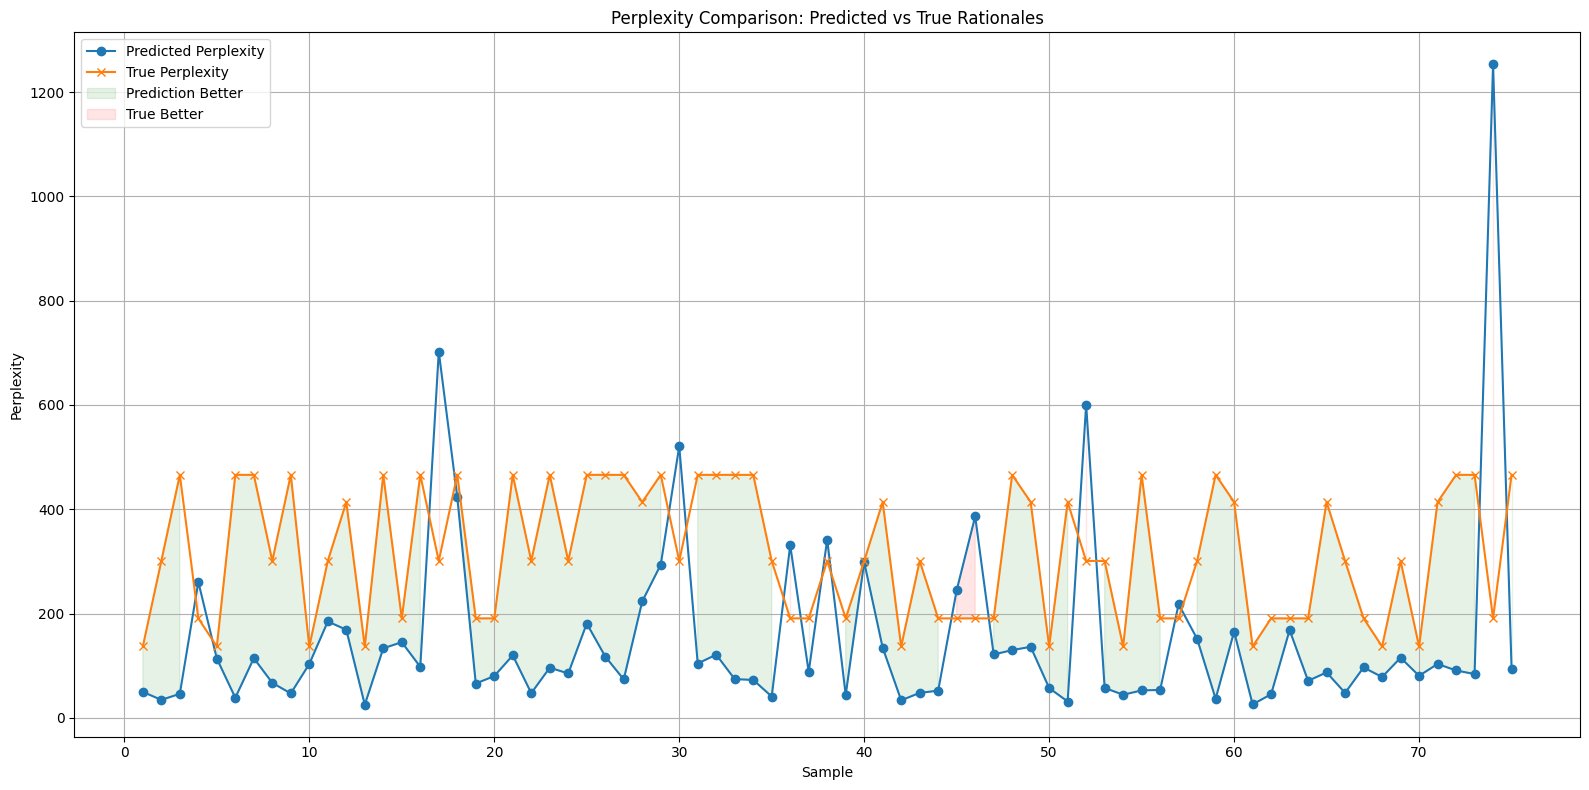

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data from the user message
data = [
    {"Sample": i + 1, "Pred": float(pred), "True": float(true), "Better": "Prediction" if better else "True"}
    for i, (pred, true, better) in enumerate([
        (49.78, 136.83, True), (34.42, 300.82, True), (46.11, 465.92, True), (260.74, 190.74, False),
        (113.71, 136.83, True), (38.56, 465.92, True), (114.29, 465.92, True), (67.08, 300.82, True),
        (46.85, 465.92, True), (103.28, 136.83, True), (184.78, 300.82, True), (168.98, 413.82, True),
        (25.22, 136.83, True), (133.37, 465.92, True), (145.08, 190.74, True), (97.76, 465.92, True),
        (702.27, 300.82, False), (423.08, 465.92, True), (65.87, 190.74, True), (80.07, 190.74, True),
        (119.86, 465.92, True), (47.34, 300.82, True), (96.18, 465.92, True), (85.11, 300.82, True),
        (180.86, 465.92, True), (117.63, 465.92, True), (73.69, 465.92, True), (223.25, 413.82, True),
        (293.58, 465.92, True), (520.76, 300.82, False), (104.20, 465.92, True), (121.17, 465.92, True),
        (74.23, 465.92, True), (72.74, 465.92, True), (40.92, 300.82, True), (331.10, 190.74, False),
        (87.93, 190.74, True), (341.92, 300.82, False), (43.80, 190.74, True), (298.48, 300.82, True),
        (134.41, 413.82, True), (33.63, 136.83, True), (47.90, 300.82, True), (52.18, 190.74, True),
        (244.73, 190.74, False), (386.24, 190.74, False), (121.52, 190.74, True), (129.88, 465.92, True),
        (136.22, 413.82, True), (57.14, 136.83, True), (31.35, 413.82, True), (600.66, 300.82, False),
        (57.41, 300.82, True), (44.30, 136.83, True), (52.64, 465.92, True), (53.49, 190.74, True),
        (217.90, 190.74, False), (151.46, 300.82, True), (36.71, 465.92, True), (165.23, 413.82, True),
        (25.79, 136.83, True), (45.26, 190.74, True), (168.27, 190.74, True), (71.00, 190.74, True),
        (87.15, 413.82, True), (47.80, 300.82, True), (96.63, 190.74, True), (78.29, 136.83, True),
        (115.30, 300.82, True), (80.62, 136.83, True), (103.30, 413.82, True), (90.87, 465.92, True),
        (84.00, 465.92, True), (1253.05, 190.74, False), (94.46, 465.92, True)
    ])
]

df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(16, 8))
plt.plot(df["Sample"], df["Pred"], label="Predicted Perplexity", marker='o')
plt.plot(df["Sample"], df["True"], label="True Perplexity", marker='x')
plt.fill_between(df["Sample"], df["Pred"], df["True"], where=(df["Better"] == "Prediction"), color='green', alpha=0.1, label="Prediction Better")
plt.fill_between(df["Sample"], df["Pred"], df["True"], where=(df["Better"] == "True"), color='red', alpha=0.1, label="True Better")
plt.xlabel("Sample")
plt.ylabel("Perplexity")
plt.title("Perplexity Comparison: Predicted vs True Rationales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


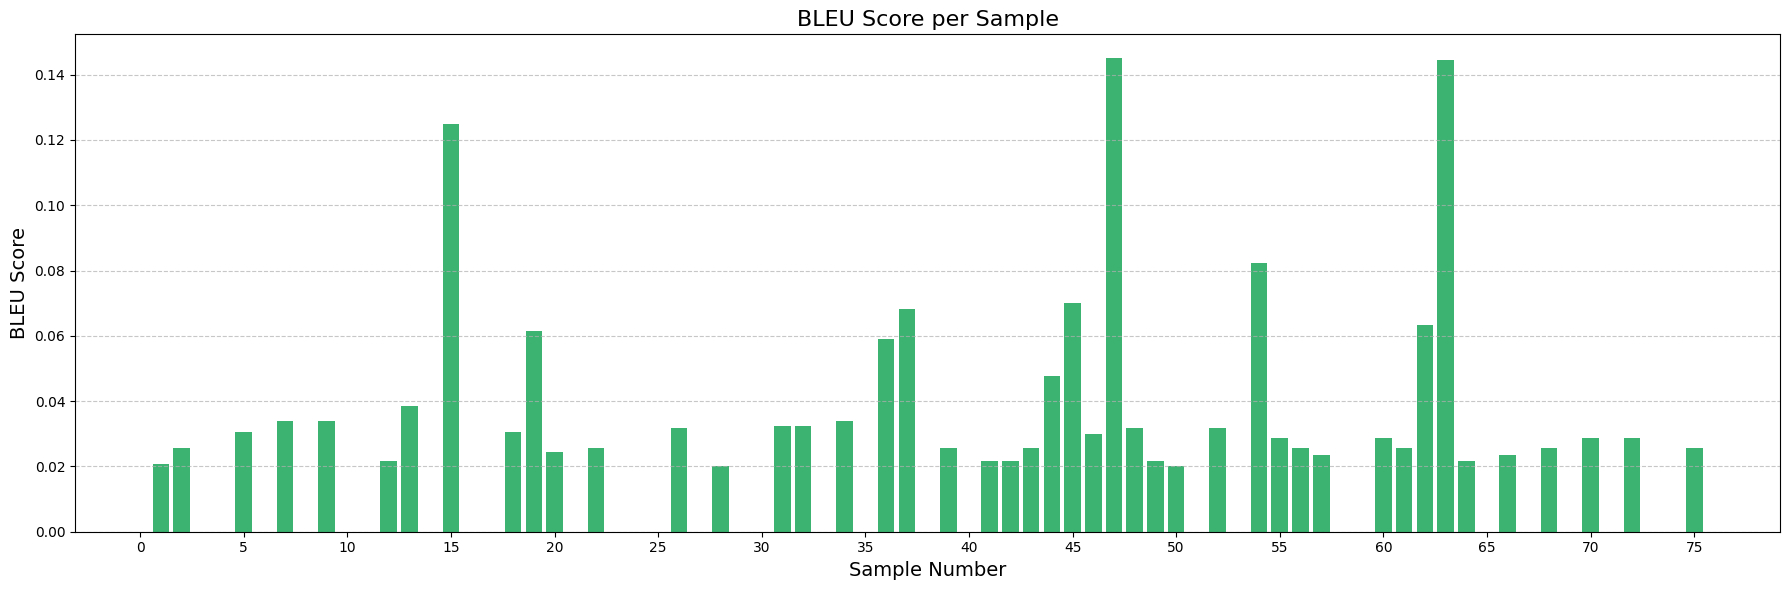

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# BLEU scores for 75 samples
bleu_scores = [
    0.0207, 0.0257, 0.0, 0.0, 0.0306, 0.0, 0.0340, 0.0, 0.0340, 0.0,
    0.0, 0.0216, 0.0385, 0.0, 0.1248, 0.0, 0.0, 0.0306, 0.0616, 0.0243,
    0.0, 0.0257, 0.0, 0.0, 0.0, 0.0318, 0.0, 0.0200, 0.0, 0.0,
    0.0324, 0.0324, 0.0, 0.0340, 0.0, 0.0589, 0.0681, 0.0, 0.0257, 0.0,
    0.0216, 0.0216, 0.0257, 0.0477, 0.0701, 0.0300, 0.1451, 0.0318, 0.0216, 0.0200,
    0.0, 0.0318, 0.0, 0.0823, 0.0286, 0.0257, 0.0235, 0.0, 0.0, 0.0286,
    0.0257, 0.0632, 0.1445, 0.0216, 0.0, 0.0235, 0.0, 0.0257, 0.0, 0.0286,
    0.0, 0.0286, 0.0, 0.0, 0.0257
]

# Plotting
plt.figure(figsize=(18, 6))
plt.bar(range(1, 76), bleu_scores, color='mediumseagreen')
plt.title('BLEU Score per Sample', fontsize=16)
plt.xlabel('Sample Number', fontsize=14)
plt.ylabel('BLEU Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(np.arange(0, 76, 5))
plt.show()
